CNN+Attention (keras)

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
import os
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model
from keras.layers.wrappers import Bidirectional
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

Using TensorFlow backend.


In [2]:
addDict={}
seq_len=20
categories=6

In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def predictVector(word, around_words_list):
    global addDict
    if word in addDict:
        return addDict[word]
    else:
        return addUnknownWord(word,around_words_list)

def addUnknownWord(word , around_words_list):
    global addDict
    rand_vector=np.random.rand(200)/np.linalg.norm(np.random.rand(200))*(10+ 3*np.random.rand(1))
    vector=np.array(model[model.predict_output_word(around_words_list)[0][0]])+rand_vector
    addDict[word]=vector
    return vector
    
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return [word for word in words if word!="「" and word!="」" and word!="、"]

def extractKeyword(text,word_class):
    tagger = MeCab.Tagger('-Ochasen')
    tagger.parse('') # <= 空文字列をparseする
    node = tagger.parseToNode(text)
    keywords = []
    while node:
        if node.feature.split(",")[0] == word_class:
            keywords.append(node.surface)
        node = node.next
    return keywords

def seq2vecs(words,predict):
    global addDict
    vectors=[]
    for i in range(len(words)):
            try:
                vectors.append(model[words[i]])
            except:
                if predict:
                    try:
                        vectors.append(predictVector(words[i],[words[i-1]]))
                    except:
                        if i==0:
                            return []
                        else:
                            similar_word=model.similar_by_vector(addDict[words[i-1]], topn=10, restrict_vocab=None)[0][0]
                            vectors.append(predictVector(words[i],[similar_word]))
                else:
                    return []
    return vectors

In [ ]:
def train_test_divide(X,Y,T,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    T_train=np.array(T[:datanum-n])
    T_test=np.array(T[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    print(len(T_train))
    print(len(T_test))
    return (X_train,Y_train,T_train),(X_test,Y_test,T_test)

def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

In [5]:
def load_data(filename,sfl,predict,extract):
    global seq_len
    X=[]
    Y=[]
    T=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            words=[]
            if extract:
                words=extractKeyword(title,"名詞")
            else:
                words=Wakati(title)
            input_vectors=seq2vecs(words,predict)
            if len(input_vectors) > seq_len:
                input_vectors=input_vectors[:seq_len]
            elif len(input_vectors)==0:
                continue
            if sfl:
                random.shuffle(input_vectors)
            x = [ [0.]*200 for _ in range(seq_len) ]
            x[0:len(input_vectors)]=input_vectors
            y=onehot_vector(int(category))
            X.append(np.array(x))
            Y.append(np.array(y))
            T.append(title)
    X,Y=shuffle(X,Y)
    X=np.array(X)
    Y=np.array(Y)
    print(X.shape)
    print(Y.shape)
    print(len(T))
    return X,Y,T

In [6]:
X,Y,T=load_data("news_data.txt",False,False,Falsedef train_test_divide(X,Y,T,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    T_train=np.array(T[:datanum-n])
    T_test=np.array(T[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    print(len(T_train))
    print(len(T_test))
    return (X_train,Y_train,T_train),(X_test,Y_test,T_test)

def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot)
(X_train,Y_train,T_train),(X_test,Y_test,T_test)=train_test_divide(X,Y,T,0.1)

/home/hikaru/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/gensim/models/word2vec.py:1316: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")


(83723, 20, 200)
(83723, 6)
83723
(75351, 20, 200)
(75351, 6)
(8372, 20, 200)
(8372, 6)
75351
8372


In [7]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = K.variable(self.init((input_shape[-1],1)))
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x,self.W))
        eij=K.squeeze(eij,axis=2)
        ai = K.exp(eij)
        Sum=K.expand_dims(K.sum(ai, axis=1),axis=1)
        weights = ai/Sum
        weights=K.expand_dims(weights,axis=1)
        weighted_input = K.batch_dot(weights, x)
        weighted_input=K.squeeze(weighted_input,axis=1)
        print(weighted_input.shape)
        return weighted_input

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [8]:
inputs = Input(shape=(seq_len, 200))
conv = Conv1D(filters=200,kernel_size=4,padding="same")(inputs)
encoded  = AttLayer()(conv)
x      = Dense(128,activation="relu")(encoded)
x      = Dense(64,activation="relu")(x)
decoded  = Dense(categories, activation='softmax')(x)
model  = Model(inputs, decoded)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history=model.fit(X_train, Y_train, validation_split=0.3,shuffle=True,epochs=20, batch_size=1000)


(?, 200)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 200)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 200)           160200    
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 200)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 194,774
Trainable params: 194,774
Non-trainable params: 0
_____________________________________________________________

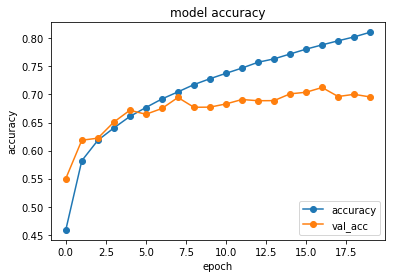

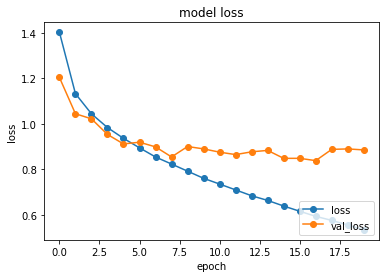

In [9]:
plot_history(history)

In [10]:
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))

8288/8372 [============================>.] - ETA: 0s
loss:0.8738579516540688 accuracy:0.7054467271289014
